In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pickle
from PIL import Image

import gc
import numpy as np
import matplotlib.pyplot as plt

import mplt_style
plt.style.use(mplt_style.style1)
import iMANGA_functions as iMANGA

from astropy.io import fits
from astropy.wcs import WCS # World coordinate system

from spectral_cube import SpectralCube    
from spectral_cube import LazyMask
import spectral_cube

import os

import copy


from astropy.io import fits
from pathlib import Path
from astropy.visualization import simple_norm

from matplotlib import rc#plt is broken
rc('text', usetex = False)


#############################
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms


#rectangular cropping function
#%run "/media/ben/home/ben/Documents/Grad Stuff/MM data/Simplified/2025/0 Imports and functions.ipynb"
%run "0_Imports.ipynb"

%matplotlib inline
#!pip show matplotlib
# imports a function called Crop_Nans
# imports the noise function "Noise_Matching"

# Load Data

In [40]:
folder = Path("Convolution_Pairs/")
########################################### Load
#################
################
normailization_tensor_img_array = []
INC_KIN_array = []
for file in folder.glob("*.pkl"):
    

    
    #save_name = "Convolution_Pairs/"+str(ID) + "_Convolution_Pair.pkl"
    
    # load
    with open(file, "rb") as f:
        data_pair = pickle.load(f)

    normailization_tensor_img,lis  = data_pair
    INC_MORPH_PETR, INC_MORPH_SERSIC, INC_KIN = lis

    normailization_tensor_img_array.append(normailization_tensor_img[0])
    #print(type(normailization_tensor_img[0]))
    INC_KIN_array.append(float(INC_KIN))

#INC_KIN_array = np.array(INC_KIN_array)
#normailization_tensor_img_array = np.array(normailization_tensor_img_array)

#INC_KIN_array = torch.stack(INC_KIN_array)  # shape: (
print(np.shape(normailization_tensor_img_array))
#print(type(normailization_tensor_img_array))
normailization_tensor_img_array = torch.stack(normailization_tensor_img_array)  # shape: (




(319, 1, 256, 256)
<class 'list'>


torch.Size([319, 1, 256, 256])
(319,)


TypeError: Invalid shape (1, 256, 256) for image data

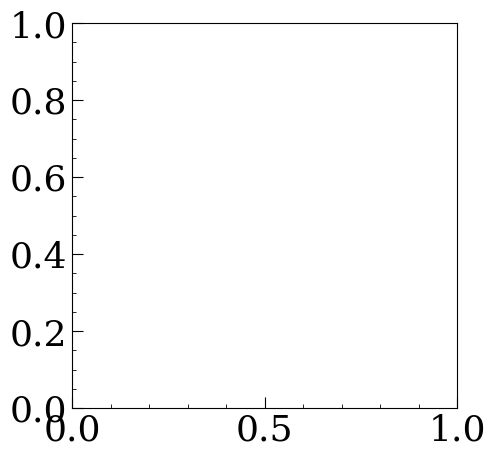

In [41]:
print(np.shape(normailization_tensor_img_array))
print(np.shape(INC_KIN_array))

from astropy.visualization import simple_norm

fig = plt.figure(1, figsize=(6, 5))
fig.patch.set_facecolor('white')
ax=plt.subplot(111)
ax.minorticks_on()
ax.tick_params(length=8, which='major', direction="in", labelsize=26)
ax.tick_params(length=3, which='minor', direction="in", labelsize=26)


im = ax.imshow(normailization_tensor_img_array[0],cmap='gray'\
              , zorder=2,interpolation='nearest', origin='lower',\
               norm=simple_norm(normailization_tensor_img_array[0], stretch='log', log_a=500))

cbar = plt.colorbar(im,ax=ax, pad = .0050, aspect=30)
cbar.ax.tick_params(labelsize=26, axis='y', direction='in', )

cbar.set_ticks([0.5*10**-17, 2*10**-17])


cbar.set_label(r'$ F_\lambda\quad\left[\,erg/\,s \,/m^2\,/\,\AA \,\,\right]$',fontsize=20);
cbar.ax.yaxis.get_offset_text().set_fontsize(24)


ax.set_xlim(94,200)
ax.set_ylim(94,200);

# Create network


In [43]:
# Download the resnet network

import torch, torch.nn as nn
import torchvision.models as models
from torchvision import transforms
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load pretrained model
model = models.resnet18(pretrained=True)

# 2) Freeze backbone
# Allows for the current weights to be unaffected; only add new ones for specificity
for param in model.parameters():
    param.requires_grad = False

# 3) Replace last layer for single-output regression
in_feats = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_feats, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1)   # single continuous output
)

#model = model.to(device)


# 4) Only params in model.fc will have requires_grad True
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()

In [65]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    #transforms.ToTensor()
])

#Create the dataset object using the training data
from torch.utils.data import Dataset

class GalaxyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images        # list or np.array of images
        self.labels = labels        # list or np.array of floats
        self.transform = transform

    def __len__(self):
        return len(self.images)
    """
    def __getitem__(self, idx):
        img = self.images[idx]


        # If grayscale with shape (256,256), add channel
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)   # (256,256,3)

        # If shape is (1,256,256), squeeze the 1
        if img.ndim == 3 and img.shape[0] == 1:
            img = np.squeeze(img, axis=0)      # (256,256)

        # Convert numpy → PIL
        img = Image.fromarray((img * 255).astype(np.uint8))

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(float(self.labels[idx]), dtype=torch.float32)
        return img, label
    """
    def __getitem__(self, idx):
        img = self.images[idx]  # already a tensor, shape (1,H,W)
        label = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)
    
        # optionally apply transforms that support tensors
        if self.transform:
            img = self.transform(img)
    
        return img, label

from torch.utils.data import DataLoader, random_split

dataset = GalaxyDataset(normailization_tensor_img_array, INC_KIN_array, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, val_loader = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(test_dataset, batch_size=16)


# Training

In [78]:
model.train()
running_loss = 0

for imgs, labels in train_loader:
    print(np.shape(imgs), np.shape(labels))
    imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)  # [B,1]
    imgs_rgb = imgs.repeat(1, 3, 1, 1)  # now [B,3,H,W]
    print(np.shape(imgs_rgb))

    preds = model(imgs_rgb)
    loss = loss_fn(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)



torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size([16, 1])
torch.Size([16, 3, 224, 224])
torch.Size([16, 1, 224, 224]) torch.Size

epoch 0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 1/300: Train Loss = 482.6474, Val Loss = 417.0894
epoch 1
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 2/300: Train Loss = 495.3837, Val Loss = 404.2358
epoch 2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 3/300: Train Loss = 492.7265, Val Loss = 426.8262
epoch 3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 4/300: Train Loss = 501.8434, Val Loss = 424.3848
epoch 4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 5/300: Train Loss = 484.3888, Val Loss = 406.2463
epoch 5
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 6/300: Train Loss = 483.0806, Val Loss = 408.5098
epoch 6
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 7/300: Train Loss = 485.1974, Val Loss = 403.4636
epoch 7
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 8/300: Train Loss = 482.4897, Val Loss = 416.9722
epoch 8
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 9/300: Train Loss = 485.3327, Val Loss = 400.9663
epoch 9
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
Epoch 10/300: Train Loss =

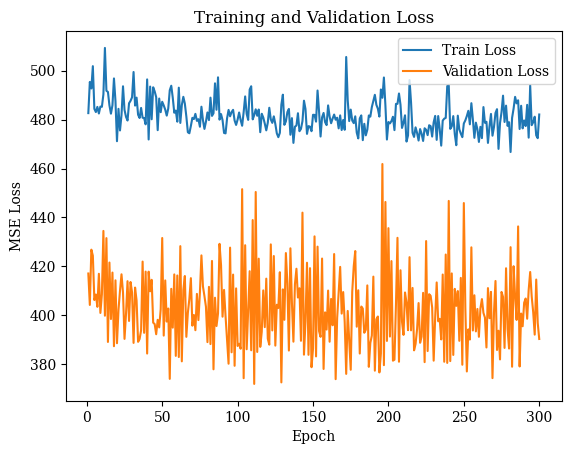

In [82]:
#for item in train_loader:
#    print(type(item))
#    break

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
"""trainig loop
for imgs, labels in train_loader:
    print(np.shape(imgs), np.shape(labels))
    imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)  # [B,1]
    imgs_rgb = imgs.repeat(1, 3, 1, 1)  # now [B,3,H,W]
    preds = model(imgs_rgb)
    loss = loss_fn(preds, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
"""   
# -------------------------
# Training + Validation
# -------------------------
epochs = 300
train_losses = []
val_losses = []

for epoch in range(epochs):
    print("epoch",epoch)
    # Training
    model.train()
    running_loss = 0
    iii=0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device).unsqueeze(1)  # [B,1]

        imgs_rgb = imgs.repeat(1, 3, 1, 1)  # now [B,3,H,W]
        preds = model(imgs_rgb)
        loss = loss_fn(preds, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        iii+=1
        print(iii)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    running_val_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs_rgb = imgs.repeat(1, 3, 1, 1)  # now [B,3,H,W]

            preds = model(imgs_rgb)
            loss = loss_fn(preds, labels.unsqueeze(1))
            running_val_loss += loss.item() * imgs.size(0)
    val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

# -------------------------
# Plot Loss
# -------------------------
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:

folder = Path("Moment_Maps/")

for file in folder.glob("*.fits"):

    
    print(file)
    Moment_0  = SpectralCube.read(file)

    data_array = Moment_0.hdu.data

    # re shape
    data_array = make_256(arr,outsize = [256,256])
    #padd iff  needed

    Tensorize = data_array.ToTensor()
    
    normailization = Tensorize.Normalize((0.5,), (0.5,))
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('.', train=False, transform=transform),
    batch_size=1000, shuffle=False
)

# ----------------------
# 2. Define CNN
# ----------------------
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolution layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)   # input=1 channel, output=32, kernel=3
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        # Fully connected layers
        self.fc1 = nn.Linear(9216, 128)  # flatten (64*12*12)
        self.fc2 = nn.Linear(128, 10)    # 10 digits

    def forward(self, x):
        x = F.relu(self.conv1(x))     # conv + ReLU
        x = F.relu(self.conv2(x))     # conv + ReLU
        x = F.max_pool2d(x, 2)        # pooling
        x = torch.flatten(x, 1)       # flatten batch dimension
        x = F.relu(self.fc1(x))       # fully connected + ReLU
        x = self.fc2(x)               # output layer
        return F.log_softmax(x, dim=1)


# Make netowrk

In [ ]:
# ----------------------
# 1. Data Loading
# ----------------------

#Load 

folder = Path("Convolution_Pairs/")



    
for file in folder.glob("*.npy"):

    
    print(file)
    convolution,incliniation  = np.load(file)
    

# ----------------------
# 3. Training
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train for 1 epoch (for demo)
model.train()
for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 200 == 0:
        print(f"Train Step {batch_idx}, Loss: {loss.item():.4f}")
    if batch_idx == 500:  # stop early for speed
        break

# ----------------------
# 4. Evaluation
# ----------------------
model.eval()
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

print(f"Test Accuracy: {correct / len(test_loader.dataset):.2%}")


In [ ]:
#FRom https://github.com/ChawDoe/LeNet5-MNIST-PyTorch/blob/master/train.py

if __name__ == '__main__':
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 256
    train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor())
    test_dataset = mnist.MNIST(root='./test', train=False, transform=ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    model = Model().to(device)
    sgd = SGD(model.parameters(), lr=1e-1)
    loss_fn = CrossEntropyLoss()
    all_epoch = 100
    prev_acc = 0
    for current_epoch in range(all_epoch):
        model.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)
            sgd.zero_grad()
            predict_y = model(train_x.float())
            loss = loss_fn(predict_y, train_label.long())
            loss.backward()
            sgd.step()

        all_correct_num = 0
        all_sample_num = 0
        model.eval()
        
        for idx, (test_x, test_label) in enumerate(test_loader):
            test_x = test_x.to(device)
            test_label = test_label.to(device)
            predict_y = model(test_x.float()).detach()
            predict_y =torch.argmax(predict_y, dim=-1)
            current_correct_num = predict_y == test_label
            all_correct_num += np.sum(current_correct_num.to('cpu').numpy(), axis=-1)
            all_sample_num += current_correct_num.shape[0]
        acc = all_correct_num / all_sample_num
        print('accuracy: {:.3f}'.format(acc), flush=True)
        if not os.path.isdir("models"):
            os.mkdir("models")
        torch.save(model, 'models/mnist_{:.3f}.pkl'.format(acc))
        if np.abs(acc - prev_acc) < 1e-4:
            break
        prev_acc = acc
    print("Model finished training")

# Use transfer learning to reduce training time with pre-trained weights

In [2]:
import torch, torch.nn as nn
import torchvision.models as models
from torchvision import transforms
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1) Load pretrained model
model = models.resnet18(pretrained=True)

# 2) Freeze backbone
for param in model.parameters():
    param.requires_grad = False

# 3) Replace head for single-output regression
in_feats = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_feats, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1)   # single continuous output
)

#model = model.to(device)


# 4) Only params in model.fc will have requires_grad True
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)
loss_fn = nn.MSELoss()


/home/ben/miniconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GeForce GTX 750 which is of cuda capability 5.0.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
    
  warnings.warn(
/home/ben/miniconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/home/ben/miniconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce GTX 750 with CUDA capability sm_50 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_70 sm_75 sm_80 sm_86 sm_90 sm_100 sm_120.
If you want to use the NVIDIA GeForce GTX 750 GPU with PyTorch, please check the instructions at https://pytorch.org/ge